# Tutorial - Deep Q-Learning 

Deep Q-Learning uses a neural network to approximate $Q$ functions. Hence, we usually refer to this algorithm as DQN (for *deep Q network*) [DQN Article](https://arxiv.org/abs/1312.5602).

The parameters of the neural network are denoted by $\theta$. 
*   As input, the network takes a state $s$,
*   As output, the network returns $Q(s, a, \theta)$, the value of each action $a$ in state $s$, according to the parameters $\theta$.


The goal of Deep Q-Learning is to learn the parameters $\theta$ so that $Q(s, a, \theta)$ approximates well the optimal $Q$-function $Q^*(s, a)$. 

In addition to the network with parameters $\theta$, the algorithm keeps another network with the same architecture and parameters $\theta^-$, called **target network**.

The algorithm works as follows:

1.   At each time $t$, the agent is in state $s_t$ and has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **replay buffer**.

2.  Choose action $a_t = \arg\max_a Q(s_t, a)$ with probability $1-\varepsilon_t$, and $a_t$=random action with probability $\varepsilon_t$. 

3. Take action $a_t$, observe reward $r_t$ and next state $s_t'$.

4. Add transition $(s_t, a_t, r_t, s_t')$ to the **replay buffer**.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_i
\right]^2
$$
where the $y_i$ are the **targets** computed with the **target network** $\theta^-$:

$$
y_i = r_i + \gamma \max_{a'} Q(s_i', a', \theta^-).
$$

5. Update the parameters $\theta$ to minimize the loss, e.g., with gradient descent (**keeping $\theta^-$ fixed**): 
$$
\theta \gets \theta - \eta \nabla_\theta L(\theta)
$$
where $\eta$ is the optimization learning rate. 

6. Every $N$ transitions ($t\mod N$ = 0), update target parameters: $\theta^- \gets \theta$.

7. $t \gets t+1$. Stop if $t = T$, otherwise go to step 2.

# 1. Imports

In [1]:
# Imports
from rlberry.agents import AgentWithSimplePolicy
from rlberry.manager import (
    AgentManager,
    evaluate_agents,
    plot_writer_data,
    read_writer_data,
)
from rlberry.wrappers import WriterWrapper
from rlberry.envs import gym_make, atari_make

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from copy import deepcopy
import gymnasium as gym


rng = np.random.default_rng(seed=42)

# 2. Define the replay buffer class

In [2]:
class ReplayBuffer:
    def __init__(self, capacity, env):
        self.capacity = capacity
        self.position = 0
        self.observations = torch.zeros((capacity, *env.observation_space.shape), dtype=torch.float32)
        self.next_observations = torch.zeros((capacity, *env.observation_space.shape), dtype=torch.float32)
        self.actions = torch.zeros((capacity, 1), dtype=torch.int64)
        self.rewards = torch.zeros((capacity,1), dtype=torch.float32)
        self.terminateds = torch.zeros((capacity,1),dtype=torch.bool)

    def push(self, state, action, reward, next_state, done):
        """Saves a transition."""
        self.observations[self.position] = torch.tensor(state)
        self.next_observations[self.position] = torch.tensor(next_state)
        self.actions[self.position] = torch.tensor(action)
        self.rewards[self.position] = torch.tensor(reward)
        self.terminateds[self.position] = torch.tensor(done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        indices = rng.choice(np.arange(self.position), size=batch_size, replace=False)
        return self.observations[indices], self.actions[indices], self.rewards[indices], self.next_observations[indices], self.terminateds[indices]

    def __len__(self):
        return self.position


# 3. Define the neural network class for the $Q$-functions

In [3]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

# 4. Implement Deep Q-Learning

In [3]:
# Create a DQN class that is interfacable with rlberry.AgentManager
class MyDQN(AgentWithSimplePolicy):
    name = "MyDQN"
    def __init__(self, env: gym.Env, 
                    gamma: float, 
                    batch_size: int, 
                    buffer_capacity: float, 
                    update_target_every: int,
                    epsilon_start: float,
                    decrease_epsilon: int,
                    epsilon_min: float,
                    replay_buffer: ReplayBuffer,
                    qnetworks: torch.nn,
                    optimizer: optim,
                    loss_fn: torch.nn,
                    **kwargs):
        AgentWithSimplePolicy.__init__(self, env, **kwargs) # Interface with rlberry API
        self.env = WriterWrapper(self.env, self.writer, write_scalar="action_and_reward")  # "action", "reward" 
        self.replay_buffer = ReplayBuffer(buffer_capacity, self.env)

        # create network and target network
        hidden_size = 64
        obs_size = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n

        self.qnet = qnetworks(obs_size, hidden_size, n_actions)
        self.qtarget = qnetworks(obs_size, hidden_size, n_actions)

        # objective and optimizer
        self.optimizer = optimizer(params=self.qnet.parameters(), lr=1e-3)
        self.loss = loss_fn

        
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every
        self.epsilon_start = epsilon_start
        self.decrease_epsilon = decrease_epsilon
        self.epsilon_min = epsilon_min
        self.replay = replay_buffer
        

    def choose_action(self, state, epsilon):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        if rng.random() < epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                return self.qnet(torch.FloatTensor(state)).argmax().item()
            

    def update(self, state, action, reward, next_state, done):
        """
        Updates qnetwork weights
        """
        
        # add data to replay buffer
        self.replay_buffer.push(state, action, reward, next_state, done)
        
        # if there is not enough samples in the buffer, we dont update the networks
        if len(self.replay_buffer) < self.batch_size:
            return np.inf
        
        # get batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        

        # compute targets y = r + gamma max_ a' Q'(s', a')
        with torch.no_grad():
            qtarget_snext = self.qtarget(torch.FloatTensor(next_states))
            qtarget_snext_maxa = torch.max(qtarget_snext, dim=1).values.reshape(self.batch_size, 1)
            targets = rewards + self.gamma * (~dones * qtarget_snext_maxa)

        predictions = self.qnet(torch.FloatTensor(states)).gather(dim=1, index=actions)
        loss = self.loss(predictions, targets)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

    def fit(self, budget=10000, **kwargs):
        state, _ = self.env.reset()
        epsilon = self.epsilon_start
        total_time_steps = 0
        episode_nb = 0
        episode_reward = 0
        while total_time_steps < budget:
            action = self.choose_action(state, epsilon)

            # take action and update replay buffer and networks
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            episode_reward += reward
            done = terminated or truncated
            loss = self.update(state, action, reward, next_state, terminated)

            # update state
            state = next_state

            # end episode if done
            if done:
                episode_nb += 1
                state, _ = self.env.reset()
                self.writer.add_scalar('episode_reward', episode_reward, global_step=total_time_steps)
                episode_reward = 0
            
            # update target network
            if total_time_steps % self.update_target_every == 0:
                self.qtarget.load_state_dict(self.qnet.state_dict())

            total_time_steps += 1
            # decrease epsilon
            epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * \
                            np.exp(-1. * total_time_steps / self.decrease_epsilon)
            self.writer.add_scalar('epsilon', epsilon)

    def policy(self, state):
        return self.qnet(torch.FloatTensor(state)).argmax().item()        

# 5. Instantiate two DQN agents to compare, one with a small batch size and one with default batch size.

In [258]:
# Environment
env_ctor = gym_make  # environment constructor
env_kwargs = {"id": "CartPole-v1"}  # parameters passed to the environment constructor. Here name of the environment

names = ["DQN", "DQN-small-batch-size"]
agent_list = [MyDQN, MyDQN]  # list of agents on which we run experiments

agent_params = [dict(gamma=0.99, 
                    batch_size=256, 
                    buffer_capacity=10000, 
                    update_target_every=1000, 
                    epsilon_start=1, 
                    decrease_epsilon=10_000, 
                    epsilon_min=0.05,
                    qnetworks=Net,
                    replay_buffer=ReplayBuffer,
                    optimizer=optim.Adam,
                    loss_fn=F.mse_loss,
                    ), 
                dict(gamma=0.99, 
                    batch_size=8, 
                    buffer_capacity=10000, 
                    update_target_every=1000, 
                    epsilon_start=1, 
                    decrease_epsilon=10_000, 
                    epsilon_min=0.05,
                    qnetworks=Net,
                    replay_buffer=ReplayBuffer,
                    optimizer=optim.Adam,
                    loss_fn=F.mse_loss,
                    )]


fit_budget = 50_000  # budgent used by an agent in one fit. This is used differently by different agents.
n_fit = 3  # number of parallel fits of the same agent.

agent_managers = [
    AgentManager(  # an AgentManager is used to repeatedly fit and evaluate an agent on an environment
        Agent,
        agent_name=names[e],
        init_kwargs=agent_params[e],
        train_env=(env_ctor, env_kwargs),
        fit_budget=fit_budget,
        n_fit=n_fit,
        eval_kwargs=dict(eval_horizon=500, n_simulations=10)
    )
    for e, Agent in enumerate(agent_list)
]

# 6. Fit the DQN agents.

In [259]:
for manager in agent_managers:
    manager.fit() 

[INFO] 16:00: Running AgentManager fit() for DQN with n_fit = 3 and max_workers = None. 


[INFO] 16:00: [DQN[worker: 2]] | max_global_step = 1302 | reward = 1.0 | action = 1 | epsilon = 0.8840238379253593 | episode_reward = 14.0 |  
[INFO] 16:00: [DQN[worker: 0]] | max_global_step = 1316 | reward = 1.0 | action = 1 | epsilon = 0.8828570215143315 | episode_reward = 36.0 |  
[INFO] 16:00: [DQN[worker: 1]] | max_global_step = 1304 | reward = 1.0 | action = 0 | epsilon = 0.883857049837139 | episode_reward = 13.0 |  
[INFO] 16:00: [DQN[worker: 2]] | max_global_step = 2415 | reward = 1.0 | action = 1 | epsilon = 0.7961763635995357 | episode_reward = 13.0 |  
[INFO] 16:00: [DQN[worker: 0]] | max_global_step = 2428 | reward = 1.0 | action = 1 | epsilon = 0.7952069645727475 | episode_reward = 22.0 |  
[INFO] 16:00: [DQN[worker: 1]] | max_global_step = 2408 | reward = 1.0 | action = 1 | epsilon = 0.7966988699099283 | episode_reward = 57.0 |  
[INFO] 16:00: [DQN[worker: 2]] | max_global_step = 3527 | reward = 1.0 | action = 1 | epsilon = 0.7176485982466707 | episode_reward = 31.0 |  


# 7. Evaluate the DQN agents on 10 episodes. Plot the mean episodic rewards.

In this [paper](https://arxiv.org/pdf/2310.03882.pdf), authors claim that a small batch size increases DQN performances.

[INFO] 16:06: Evaluating DQN... 
[INFO] Evaluation:..........  Evaluation finished 
[INFO] 16:06: Evaluating DQN-small-batch-size... 
[INFO] Evaluation:..........  Evaluation finished 


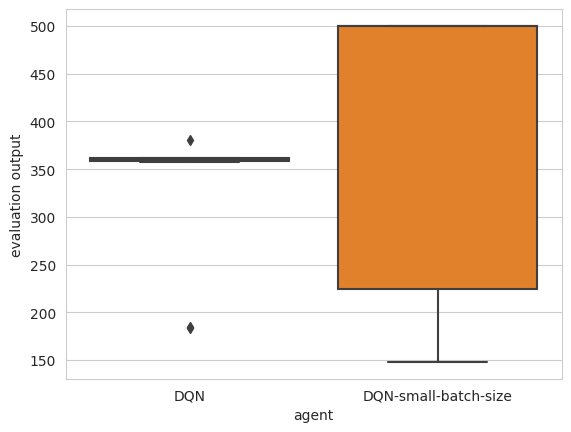

In [260]:
output = evaluate_agents(agent_managers, n_simulations=10, plot=True)

# 8. Plot the episodic rewards during learning.

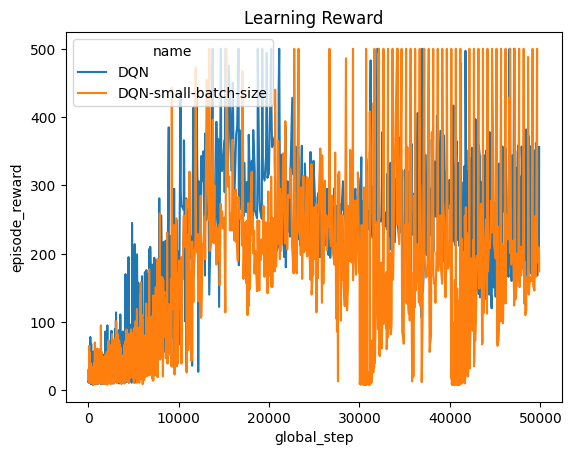

In [261]:
output_mydqn = plot_writer_data(
    agent_managers,
    tag="episode_reward",
    title="Learning Reward",
)

# 9. Bonus: modify the Net class so that Q networks take images as input and use rlberry.envs.atari_make("AtariGame") to train DQN on Pong .

In [12]:
# class CNNNetwork(torch.nn.Module):
#     """
#     Basic CNN Qnetwork.
#     """
#     def __init__(self, obs_size, hidden_size, n_actions):
#         super(CNNNetwork, self).__init__()
#         n_input_channels = obs_size
#         self.cnn = nn.Sequential(
#             nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(),
#             nn.Flatten(),
#         )

#         self.linear = nn.Sequential(nn.LazyLinear(hidden_size), nn.ReLU(), nn.Linear(hidden_size, n_actions))

#     def forward(self, observations):
#         return self.linear(self.cnn(observations))
    

# # Environment
# env_ctor = atari_make  # environment constructor
# env_kwargs = {"id": "ALE/Pong-v5"}  # parameters passed to the environment constructor. Here name of the environment
# names = ["DQN", "DQN-small-batch-size"]
# agent_list = [MyDQN, MyDQN]  # list of agents on which we run experiments

# agent_params = [dict(gamma=0.99, 
#                     batch_size=256, 
#                     buffer_capacity=10000, 
#                     update_target_every=1000, 
#                     epsilon_start=1, 
#                     decrease_epsilon=10_000, 
#                     epsilon_min=0.05,
#                     qnetworks=CNNNetwork,
#                     replay_buffer=ReplayBuffer,
#                     optimizer=optim.Adam,
#                     loss_fn=F.mse_loss,
#                     ), 
#                 dict(gamma=0.99, 
#                     batch_size=8, 
#                     buffer_capacity=10000, 
#                     update_target_every=1000, 
#                     epsilon_start=1, 
#                     decrease_epsilon=10_000, 
#                     epsilon_min=0.05,
#                     qnetworks=CNNNetwork,
#                     replay_buffer=ReplayBuffer,
#                     optimizer=optim.Adam,
#                     loss_fn=F.mse_loss,
#                     )]


# fit_budget = 50_000  # budgent used by an agent in one fit. This is used differently by different agents.
# n_fit = 3  # number of parallel fits of the same agent.

# agent_managers = [
#     AgentManager(  # an AgentManager is used to repeatedly fit and evaluate an agent on an environment
#         Agent,
#         agent_name=names[e],
#         init_kwargs=agent_params[e],
#         train_env=(env_ctor, env_kwargs),
#         fit_budget=fit_budget,
#         n_fit=n_fit,
#         eval_kwargs=dict(eval_horizon=500, n_simulations=10)
#     )
#     for e, Agent in enumerate(agent_list)
# ]
# for manager in agent_managers:
#     manager.fit() 